In [913]:
# import libs

import numpy as np
import Laser
import gCode
import random
import Printer
import os


# Important definition
positive angle in CCW direction

### Units
Distances: mm  
Angles: degrees

# Define functions

In [914]:
#GLOBAL VARIABLES FOR DEBUGGING
d = 10

# global variables
firstLayer = 0

laserPWM = 1.00


fanPWM0 = 0.80
fanPWM1 = 1.00

In [915]:
# global debug
asd = []
asdd = []
asr = []

In [916]:
# read G-Code file and return a list of strings
def read_gcode_file(filename):
    tmp = []
    with open(filename, 'r') as f:
        gcode = f.readlines()
    for line in gcode:
        tmp.append(line)
    
    return np.array(tmp)
    

In [917]:
def parseCoord(gCodeObj,linestring):
    line = linestring
    X = None
    Y = None
    Z = None
    E = None
    F = None
    move = False

    # check the command of the gcode line (string until first space)
    command = line.split(' ')[0]

    # check if line is ;LAYER:1 and gCodeObj.firstLayerCheck is False
    if line.startswith(';LAYER:5') and not gCodeObj.firstLayerCheck:
        gCodeObj.updateFirstLayerCheck(True)
        print("First layer check is True")

    # check if FirstLayerCheck == True and a new G1 or G0 command 
    if (gCodeObj.checkFirstLayer):
        if ((command == "G1") or (command == "G0")):
            if (gCodeObj.getHistoryMovementCommandCheck() == False):
                if (gCodeObj.getFirstMovementCommandCheck() == False):
                    gCodeObj.updateFirstMovementCommandCheck(True)
            else:
                gCodeObj.updateFirstMovementCommandCheck(False)


    # check if firstLayerCheck is True -> implented in processGcode
    #if gCodeObj.firstLayerCheck:
    if (1):
        # if command == G1 or G0 than move = True
        if command == 'G1' or command == 'G0':
            move = True
        if command == 'G1':
            gCodeObj.updateNumberOfG1()
            
        # check if line contains ; which means it is a comment or one of the instructions lines in the beginning and needs to be skipped 
        if not ';' in line:
            # parse the X Y Z coords from string to float, and the values of F and E
            if 'X' in line:
                X = float(line.split('X')[-1].split(' ')[0])
                gCodeObj.lastX = X
            elif 'X' not in line:
                X = None
                X = gCodeObj.lastX
            if 'Y' in line:
                Y = float(line.split('Y')[-1].split(' ')[0])
                gCodeObj.lastY = Y
            elif 'Y' not in line:
                Y = None
                Y = gCodeObj.lastY
            if 'Z' in line:
                Z = float(line.split('Z')[-1].split(' ')[0])
                gCodeObj.lastZ = Z
            elif 'Z' not in line:
                Z = None
                Z = gCodeObj.lastZ
            if 'E' in line:
                E = float(line.split('E')[-1].split(' ')[0])
                gCodeObj.lastE = E
            elif 'E' not in line:
                E = None
                E = gCodeObj.lastE
            if 'F' in line:
                F = float(line.split('F')[-1].split(' ')[0])
                gCodeObj.lastF = F
            elif 'F' not in line:
                F = None
                F = gCodeObj.lastF
    else:
        X = None
        Y = None
        Z = None
        E = None
        F = None
    return move, X, Y, Z, E, F, command, linestring


In [918]:
# calculate the distance between two points
def calcDistance(x0, y0, x1, y1, lineNumber):
    try:
        return np.sqrt((x1-x0)**2 + (y1-y0)**2)
    except:
        print("DistanceCALC Error in Line: " +str(lineNumber))
        print(type(x0), type(y0), type(x1), type(y1))
        print(x0, y0, x1, y1)


In [919]:
# calculate angle between two points (atan2)
def calcAngle(x0, y0, x1, y1, lineNumber):
    global asd
    try:
        newAngle = np.arctan2((y1-y0),(x1-x0))
    
        # convert to degrees
        newAngle = np.rad2deg(newAngle)

        # round to 3 decimals
        newAngle = round(newAngle,2)


        # threshold for angle
        if (np.abs(newAngle) < 0.1):
            newAngle = 0.00

        asd.append(newAngle)

        return newAngle
    
    except:
        print("AngleCALC Error in LineNumber: " + str(lineNumber))
    

In [920]:
def findClosestAngle(targetAngle, LaserObj, i):

    global asdd

    targetAngle = np.array(targetAngle)
    currentAngle = LaserObj.getNormAngles()

    # copy angles
    targetAngle_origin = targetAngle
    currentAngle_origin = currentAngle

    # modulate angles with 360
    targetAngle = np.mod(targetAngle, 360)
    currentAngle = np.mod(currentAngle, 360)

    delta = targetAngle - currentAngle
    tmp = np.zeros(np.size(delta))

    # loop through delta array
    for i in range(np.size(delta)):
        d = delta[i]
        if(d < -180):
            d += 360
        elif(d >= 180):
            d -= 360
        tmp[i] = d
    
    delta = tmp

    # find the index of the closest angle
    closestAngleIndx = np.argmin(np.abs(delta))
    deltaAngle = delta[closestAngleIndx]


    if(deltaAngle > 45.5):
        print("Line: " + str(i) + "DeltaAngle is bigger than 5°: " + str(deltaAngle) + " target: " + str(targetAngle))

    # round the values
    deltaAngle = round(deltaAngle, 2)

    asdd.append(deltaAngle)


    return closestAngleIndx, deltaAngle, currentAngle

    

In [921]:

def convertAngleToSteps(angle):
    return angle


In [922]:
def deactivateAllLaser(newFilePath, laserObj, laserStringOffset):
    for l in range(len(laserObj.LaserStates)):
        newLine02 = "M106 P" + str(l+laserStringOffset) + " S0.0    ;deactivateAllLaser\n"
        laserObj.updateLaserStates(l, 0)
        with open(newFilePath, 'a') as f:
            f.write(newLine02)
            f.close()  
    return

In [923]:
def deativateONLaser(newFilePath, laserObj, laserStringOffset):
    for l in range(len(laserObj.LaserStates)):
        if(laserObj.LaserStates[l] == 1):
                # deactivate
                laserObj.updateLaserStates(l, 0)
                deactCmd = "M106 P" + str(l+laserStringOffset) + " S0   ;deactivateONLaser\n"
                with open(newFilePath, 'a') as f:
                    f.write(deactCmd)
                    f.close() 
                

In [924]:
def appendToFile(newFilePath, string):
    with open(newFilePath, 'a') as f:
        f.write(string)
        f.close()
    return

In [925]:
## Function to extract the parsersInformation to a csv
# data to be stored

def save2csv(data, filepath):
    move1, X1, Y1, Z1, E1, F1, A1, dist, delta, command1, line1 = data 

    # if command1 contains "\n" remove it
    if "\n" in command1:
        command1 = command1.replace("\n", "")

    # write to csv file
    with open(filepath, 'a') as f:
        #f.write(str(line1))
        f.write(str(move1) + ";" + str(X1) + ";" + str(Y1) + ";" + str(Z1) + ";" + str(E1) + ";" + str(F1) + ";" + str(A1) + ";" + str(dist) + ";" + str(delta) + ";" + str(command1) + ";" + str(line1) + "\n")
        f.close()



In [926]:
# wuem: thresholdAngleRetract added

def processGcode(gCodeFile, thresholdDistance, thresholdAngle, thresholdAngleRetract, laserObj, newFilePath, gCodeObj):
  
    # number of end lines
    endLines = 11
    layerEnd = 0

    minimalDistThreshold = 2.0

    ### processing parameters
    #  define string offset for physical laser connection
    laserStringOffset = 2

    
    # speeds for G0 and G1
    F0 = 3600
    F1 = 1200

    ### Include start file parameter
    # deactivate all lasers
    deactivateAllLaser(newFilePath=newFilePath, laserObj=laserObj, laserStringOffset=laserStringOffset)

    # add movement to X0.0 Y0.0 Z0.2 for test line bottom left corner
    moveCMD = "G1 X0 Y0 Z0.2"

    # activate fan
    fanPWM = fanPWM0
    activateFanCMD = "M106 P6 S" + str(fanPWM0) + "\n"
    appendToFile(newFilePath, activateFanCMD)

    # laserPWM is set in global variables
    global laserPWM

    if(1):
        csvPath = "Output/debug.csv"
        if os.path.isfile(csvPath):
            # delete file
            os.remove(csvPath)
    
        if not os.path.isfile(csvPath):
            with open(csvPath, 'w') as f:
                f.write("move;X;Y;Z;E;F;A;command;line\n")
                f.close() 

    absAngle = 0


    ### start loop through entire gcode
    for i in range(gCodeFile.shape[0]-endLines):

        tmp = 0

        # step by step
        if (d==1):
            P = 1
            #input()


        # read line and compare to current pos which is saved in gCodeObj
        move1, X1, Y1, Z1, E1, F1, command1, line1 = parseCoord(gCodeObj, gCodeFile[i])

        # if line1 == ;layer4 change fanPWM to fanPWM1 and write line M106 P6 S+str(fanPWM)
        if(line1.startswith(";LAYER:4")):
            fanPWM = fanPWM1
            activateFanCMD = "M106 P6 S" + str(fanPWM) + "\n"
            appendToFile(newFilePath, activateFanCMD)

         # get current pos
        X0, Y0, Z0, A0 = gCodeObj.getCurrentPos()
        A0 = laserObj.getAbsLaserPos()

        
        if(d==1):
            # remove \n from line1
            line1n = line1.replace("\n", "")
            # save data to csv
            save2csv([move1, X1, Y1, Z1, E1, F1, A0,0,0,command1, line1n], csvPath)

        # check for firstMovementCommandCheck and write coords into currentPos, no further processing
        if(gCodeObj.getFirstMovementCommandCheck()):
            gCodeObj.updateCurrentPos([X1, Y1, Z1, 0])
            
        
       

        # if layer is 240 set layerEnd to 1
        if(line1.startswith(";LAYER:285")):
            layerEnd = 1

        if(layerEnd == 0):

            # only execute rotation and laser ON OFF if line is a G1
            if((command1 == "G1" or command1 == "G0") and (gCodeObj.checkFirstLayer())):

                if(d==2):
                    p = 1
                    #print("Command is G1 or G0 and first layer check is True")


                # calculate distance
                try:
                    distance = calcDistance(x0=X0, y0=Y0, x1=X1, y1=Y1, lineNumber=i+1)
                    # update total distance 
                    if(command1 == "G1"):
                        gCodeObj.updateTotalLengthOfG1(distance)

                except:
                    print("Error in calculating distance. Line: " + str(i+1))

                

                # calculate angle
                try:
                    angle = calcAngle(x0=X0, y0=Y0, x1=X1, y1=Y1, lineNumber=i+1)
                except:
                    print("Error in calculating angle. Line: " + str(i+1))
                    angle = gCodeObj.getLastAngle()
                lastAngle = gCodeObj.getLastAngle()

                # normalize the target angle between 0 and 360 degrees
                #try:
                targetAngle = angle

                
                
                # command string will be filled during the if statements
                command = ""

                


                # if command is G0 ensure that no laser is activated
                if(command1 == "G0"):
                    deativateONLaser(newFilePath, laserObj, laserStringOffset)
                    
                if(command1 == "G1"):


                    # find the closest angle to the target angle
                    closestAngleIndx, deltaAngle, currentAngles = findClosestAngle(targetAngle, laserObj,i)
                    print(deltaAngle, i)
                    
                    clstIndx = closestAngleIndx

                    # get absolute angle for rotation command
                    absAngle = laserObj.getAbsLaserPos()

                    # check if any laser is activated, if yes and not the closestIndx than deactivate
                    for l in range(len(laserObj.LaserStates)):
                        if(laserObj.LaserStates[l] == 1):
                            if(l != closestAngleIndx):
                                # deactivate
                                deactCmd = "M106 P" + str(l+laserStringOffset) + " S0\n"
                                appendToFile(newFilePath=newFilePath, string=deactCmd)
                                laserObj.updateLaserStates(l, 0)
                    #print("init Laserstates: " + str(laserObj.LaserStates))


                    if(d==1):
                        print("G1 command, distance: " + str(distance) + " threshold: " + str(thresholdDistance) + " deltaAngle: " + str(deltaAngle) + " threshold: " + str(thresholdAngle)+"\n")
                    
                    
                    
                    if(distance >= thresholdDistance):
                    ### MODE Straights   
                        if(d==1):
                            print("STRAIGHT MODE, Line: " + str(i+1))

                        # update absolute angle
                        absAngle += deltaAngle
                        
                        # update laser angles
                        laserObj.updateAngles(deltaAngle)
                        

                        if (d==1):
                            command+="; STRAIGHT ** Current Pos: X" + str(X0) + " ; Y" + str(Y0) + " ; Z" + str(Z0) + " ; A" + str(A0) + "; Aabs " + str(absAngle) + " dA" + str(deltaAngle) + " calcA" + str(angle) + " target" + str(targetAngle) + " Indx" +str(clstIndx) + "\n"
                            print("Z1: " + str(Z1) + " Line: " + str(i+1))


                        # wuem: if Angle dif < threshold then add a Retract and added round
                        # rotate laser
                        if (abs(deltaAngle) >= thresholdAngleRetract):
                            command += "; Rotate case0" '\n'
                            command += "G1 E-1 F" + str(F0) + '\n'
                            command += "G1 Z" + str(Z1+0.5) + "\n"
                            command += "G0 A" + str(round(absAngle,1)) + '\n'
                            command += "G1 Z" + str(Z1) + "\n"
                            command += "G1 E1 \n"
                            command +=  "G1 F" + str(F1) + "\n"
                        else:
                            command += "; Rotate case1" '\n'
                            command += "G0 F" + str(F0) + " A" + str(round(absAngle,1)) + '\n'
                            command += "G1 F" + str(F1) + "\n" 
    
                        

                        # if laser not turned on yet, activate
                        if(laserObj.getLaserStates(closestAngleIndx) == 0):
                            # activate laser 
                            command += "M106 P" + str(closestAngleIndx+laserStringOffset) + " S" + str(laserPWM) + "\n"
                            # update laserstate
                            laserObj.updateLaserStates(closestAngleIndx, 1)

                        if (d==1):
                            command += ";Laserstates " + str(laserObj.LaserStates) + " CurrAngles " + str(laserObj.getNormAngles()) + "\n"
                        # insert G1 line
                        #command += line1 + "\n"
                        # deactivate laser
                        # command += "M106 P" + str(closestAngleIndx+laserStringOffset) + " S" + str(0.0) + "\n"
                        
                        # update lastAngle   --->3
                        gCodeObj.updateLastAngle(absAngle)


                    elif((abs(deltaAngle) <= thresholdAngle)and(distance < thresholdDistance) and (distance > minimalDistThreshold)):
                    ### MODE Curves
                        global asr
                        asr.append([deltaAngle, distance])
                        print("CURVE MODE, Line: " + str(i+1))

                        # update absolute angle
                        absAngle += deltaAngle

                        # update laser angles
                        laserObj.updateAngles(deltaAngle)

                        # if laser not turned on yet, activate
                        if(laserObj.getLaserStates(closestAngleIndx) == 0):
                            if (d==2):
                                command +=";CURVE MODE**Current Pos: X" + str(X0) + " ; Y" + str(Y0) + " ; Z" + str(Z0) + " ; A" + str(A0) + " Indx" +str(clstIndx) + "\n"
                            # activate laser 
                            command += "M106 P" + str(closestAngleIndx+laserStringOffset) + " S" + str(laserPWM) + "\n"
                            # update laserstate
                            laserObj.updateLaserStates(closestAngleIndx, 1)

                        


                        # if line1 contains "\n" remove it
                        if "\n" in line1:
                            line1 = line1.replace("\n", "")
                        command += line1 + " A" + str(round(absAngle,1)) #wuem: added round


                        if (d==2):
                            command += " ;CurveMode, Laserstates" + str(laserObj.LaserStates)+ "\n"
                        else:
                            command += "\n"

                        # check if the needed laser is 
                else:
                    # no laser activated
                    tmp = 1
                    command = line1  
                # write to file
                appendToFile(newFilePath=newFilePath, string=command)

                # update currentPos in gCodeObj
            gCodeObj.updateCurrentPos([X1, Y1, Z1, absAngle])

                



                # update states of the lasers
                # if laser not turned on yet, activate
                
                

            if(0):
                    if(laserObj.getLaserStates(closestAngleIndx) == 0):
                        # activate laser 
                        actCmd = "M106 P" + str(closestAngleIndx+laserStringOffset) + " S" + str(laserPWM) + "  ;Line233\n"
                        # update laserstate
                        laserObj.updateLaserStates(closestAngleIndx, 1)
                        with open(newFilePath, 'a') as f:
                            f.write(actCmd)
                            f.close()
                    


            elif(tmp == 0):
                #appendToFile(newFilePath, ";case2"+line1 + ";line1 string is:" + line1)
                appendToFile(newFilePath, line1)

        
        else:
                appendToFile(newFilePath, line1)

        if (d==2):
            try:
                lastCoords = ("X0: " +str(X0) + " Y0: " + str(Y0) + " Z0: " + str(Z0) + " A0: " + str(A0) + "\n")
                
            except:
                lastCoors = ("NO NEW COORDS")
            appendToFile(newFilePath, lastCoords)
        # append last coords to file
        


    # append the last 11 lines
    # check if any laser is on and turn off
    deactivateAllLaser(newFilePath, laserObj, laserStringOffset)
    # append line0 to newFilePath
    with open(newFilePath, 'a') as f:
        f.write(line1)
        f.close()

    for i in range(endLines):
        with open(newFilePath, 'a') as f:
            f.write(gCodeFile[-11+i]+ "\n")
            f.close()


In [927]:
# Add start lines to GCODE


# Test functions

In [928]:
# test calcAngle function
if (0):
    print(calcAngle(0,0,0,0))
    print(calcAngle(0,0,1,-1))
    print(calcAngle(0,0,-1,-1))
    print(calcAngle(0,0,-1,1))


In [929]:
# test the parseCoord function
if(0):

# read the gcode file
    gcode = read_gcode_file("GCODE.txt")

    # create empty lists for the coordinates
    X = []
    Y = []
    Z = []
    cmd = []
    i = 0
    # loop over all lines in the gcode file
    for line in gcode:
        #print(i)
        #i += 1
        # parse the coordinates from the line
        moveBool, x, y, z, command, linestring = parseCoord(line)
        # append the coordinates to the lists
        X.append(x)
        Y.append(y)
        Z.append(z)
        cmd.append(command)

# print first 10 elements of X Y Z
j = 50
if(0):
    for i in range(j):
        print(f"X: {X[i]} Y: {Y[i]} Z: {Z[i]} cmd: {cmd[i]}")

# Main 

In [930]:
# initiate Printer object, for duration calculation of process
Prusa = Printer.Printer(velocity_trans=100, velocity_rot=100)

fileName = "PI3MK3M_Tensile_Testing_V4"

# read the gcode file
gcode = read_gcode_file("Input/"+fileName+".gcode")
gCodeObj = gCode.gCode("gCode")

# print shape of gcode
print(gcode.shape)

# create laser object
numberOfLaser = 4
laser = Laser.Laser(numberOfLaser)

# threshold for the distance between two points 
minDistance = 5
# threshold for the angle between two points
minAngle = 10
# threshold for the retract
minAngleRetract = 5

# check index in Output/index.txt
with open("Output/index.txt", 'r') as f:
    index = int(f.read())
    f.close()

# create new file
newFilePath = "Output/" + fileName + "_processed.gcode"

# check if file size is not 0
if os.path.isfile(newFilePath):
    # delete file
    os.remove(newFilePath)


# print LaserStates
print(laser.LaserStates)



# iterate index in Output/index.txt
with open("Output/index.txt", 'w') as f:
    f.write(str(index+1))
    f.close()

# post process the gcode
print(processGcode(gcode, minDistance, minAngle, minAngleRetract, laser, newFilePath, gCodeObj))


(29316,)
[0. 0. 0. 0.]
First layer check is True
0.0 712
0.0 713
0.0 714
0.0 715
0.0 720
0.0 721
0.0 722
0.0 723
0.0 728
0.0 729
0.0 730
0.0 731
0.0 733
0.0 735
0.0 737
0.0 739
0.0 741
0.0 743
0.0 745
0.0 747
0.0 749
0.0 751
0.0 753
0.0 755
0.0 757
0.0 759
0.0 761
0.0 763
0.0 765
0.0 767
0.0 769
0.0 771
0.0 773
0.0 775
0.0 777
0.0 779
0.0 781
0.0 783
0.0 785
0.0 787
0.0 789
0.0 791
0.0 793
0.0 795
0.0 796
0.0 806
0.0 807
0.0 808
0.0 809
0.0 812
0.0 813
0.0 814
0.0 815
0.0 820
0.0 821
0.0 822
0.0 823
0.0 825
0.0 827
0.0 829
0.0 831
0.0 833
0.0 835
0.0 837
0.0 839
0.0 841
0.0 843
0.0 845
0.0 847
0.0 849
0.0 851
0.0 853
0.0 855
0.0 857
0.0 859
0.0 861
0.0 863
0.0 865
0.0 867
0.0 869
0.0 871
0.0 873
0.0 875
0.0 877
0.0 879
0.0 881
0.0 883
0.0 885
0.0 887
0.0 888
0.0 898
0.0 899
0.0 900
0.0 901
0.0 906
0.0 907
0.0 908
0.0 909
0.0 914
0.0 915
0.0 916
0.0 917
0.0 919
0.0 921
0.0 923
0.0 925
0.0 927
0.0 929
0.0 931
0.0 933
0.0 935
0.0 937
0.0 939
0.0 941
0.0 943
0.0 945
0.0 947
0.0 949
0.0 951

In [931]:
print(gCodeObj.firstLayerCheck)
print(laser.absLaserMovement)
print("Total lenght of G1 commands:\t " + str(gCodeObj.getTotalLengthOfG1()) + " mm")
print("Total angle turned: \t" + str(laser.getAbsLaserMovement()))
print("Total number of G1 commands: \t\t" + str(gCodeObj.getNumberOfG1()))



True
23.020000000000145
Total lenght of G1 commands:	 76576.29051184715 mm
Total angle turned: 	23.020000000000145
Total number of G1 commands: 		16193


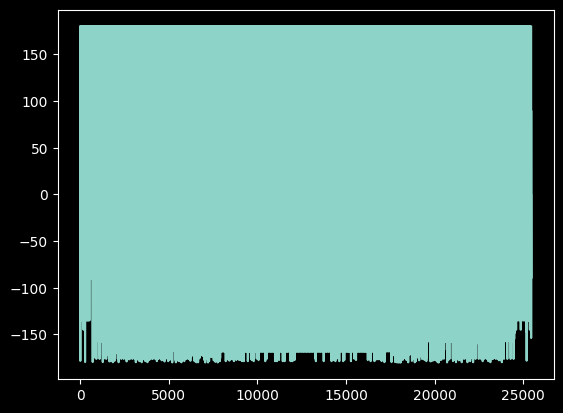

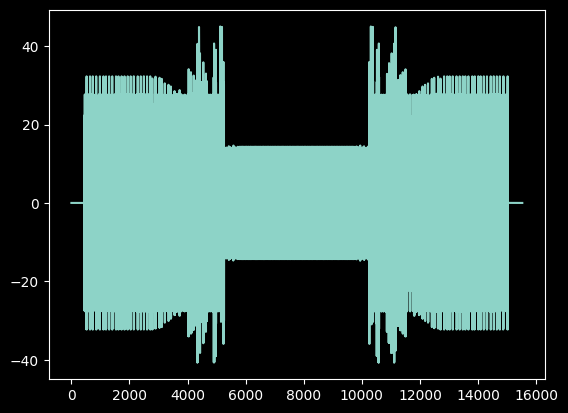

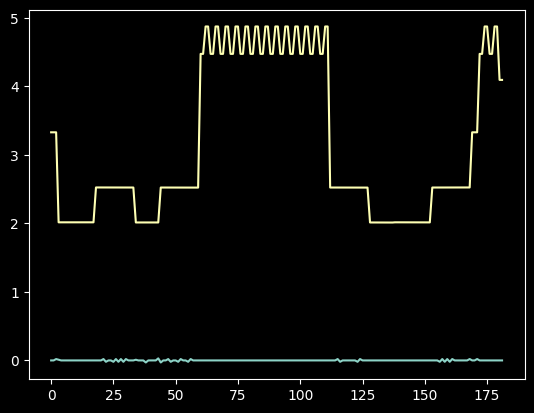

In [932]:
import matplotlib.pyplot as plt
plt.plot(asd)
plt.show()

plt.plot(asdd)
plt.show()

plt.plot(asr)
plt.show()